<a href="https://colab.research.google.com/github/skamranh/big-data-final/blob/main/Cardio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference
- https://www.kaggle.com/datasets/captainozlem/framingham-chd-preprocessed-data

In [ ]:
!pip install pyspark
!pip install -q findspark

import pyspark
import findspark
findspark.init()
from pyspark.sql import SparkSession

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns
import pyspark.pandas as ps

spark = SparkSession.builder.appName('wine').getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# dataset_loc = "data/CHD_preprocessed.csv"
dataset_loc = "/content/drive/MyDrive/Dataset/CHD_preprocessed.csv"
chd_spark = spark.read.csv(dataset_loc, header="true", inferSchema=True)
chd_pd = pd.read_csv(dataset_loc)
chd_ps = ps.read_csv(dataset_loc)

In [ ]:
chd_ps.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,1,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [ ]:
chd_spark.schema

StructType(List(StructField(male,IntegerType,true),StructField(age,IntegerType,true),StructField(education,IntegerType,true),StructField(currentSmoker,IntegerType,true),StructField(cigsPerDay,DoubleType,true),StructField(BPMeds,DoubleType,true),StructField(prevalentStroke,IntegerType,true),StructField(prevalentHyp,IntegerType,true),StructField(diabetes,IntegerType,true),StructField(totChol,DoubleType,true),StructField(sysBP,DoubleType,true),StructField(diaBP,DoubleType,true),StructField(BMI,DoubleType,true),StructField(heartRate,DoubleType,true),StructField(glucose,DoubleType,true),StructField(TenYearCHD,IntegerType,true)))

In [ ]:
chd_ps.shape

(4133, 16)

In [ ]:
chd_ps.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 4133 entries, 0 to 4132
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4133 non-null   int32  
 1   age              4133 non-null   int32  
 2   education        4133 non-null   int32  
 3   currentSmoker    4133 non-null   int32  
 4   cigsPerDay       4133 non-null   float64
 5   BPMeds           4133 non-null   float64
 6   prevalentStroke  4133 non-null   int32  
 7   prevalentHyp     4133 non-null   int32  
 8   diabetes         4133 non-null   int32  
 9   totChol          4133 non-null   float64
 10  sysBP            4133 non-null   float64
 11  diaBP            4133 non-null   float64
 12  BMI              4133 non-null   float64
 13  heartRate        4133 non-null   float64
 14  glucose          4133 non-null   float64
 15  TenYearCHD       4133 non-null   int32  
dtypes: float64(8), int32(8)

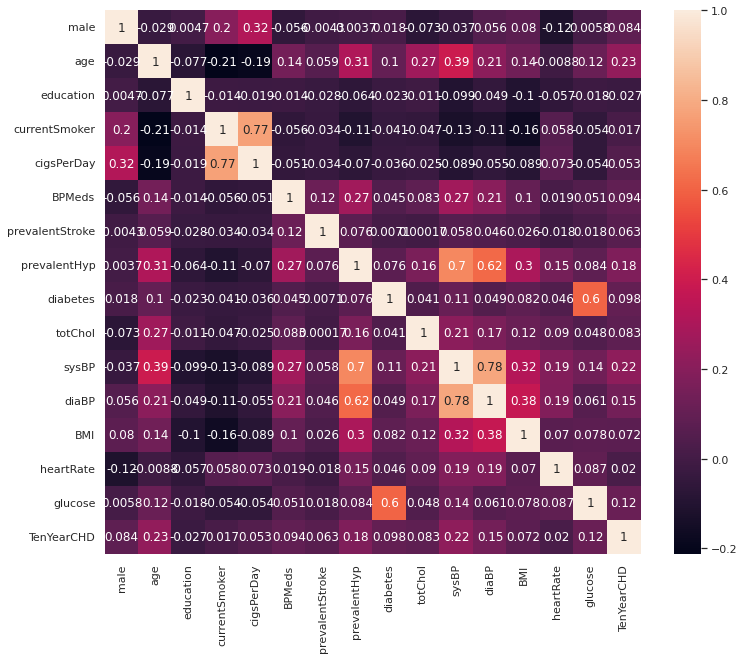

In [ ]:
plt.rcParams['figure.figsize'] = [12, 10]
sns.set(font_scale = 1)
sns.heatmap(chd_pd.corr(), annot = True)

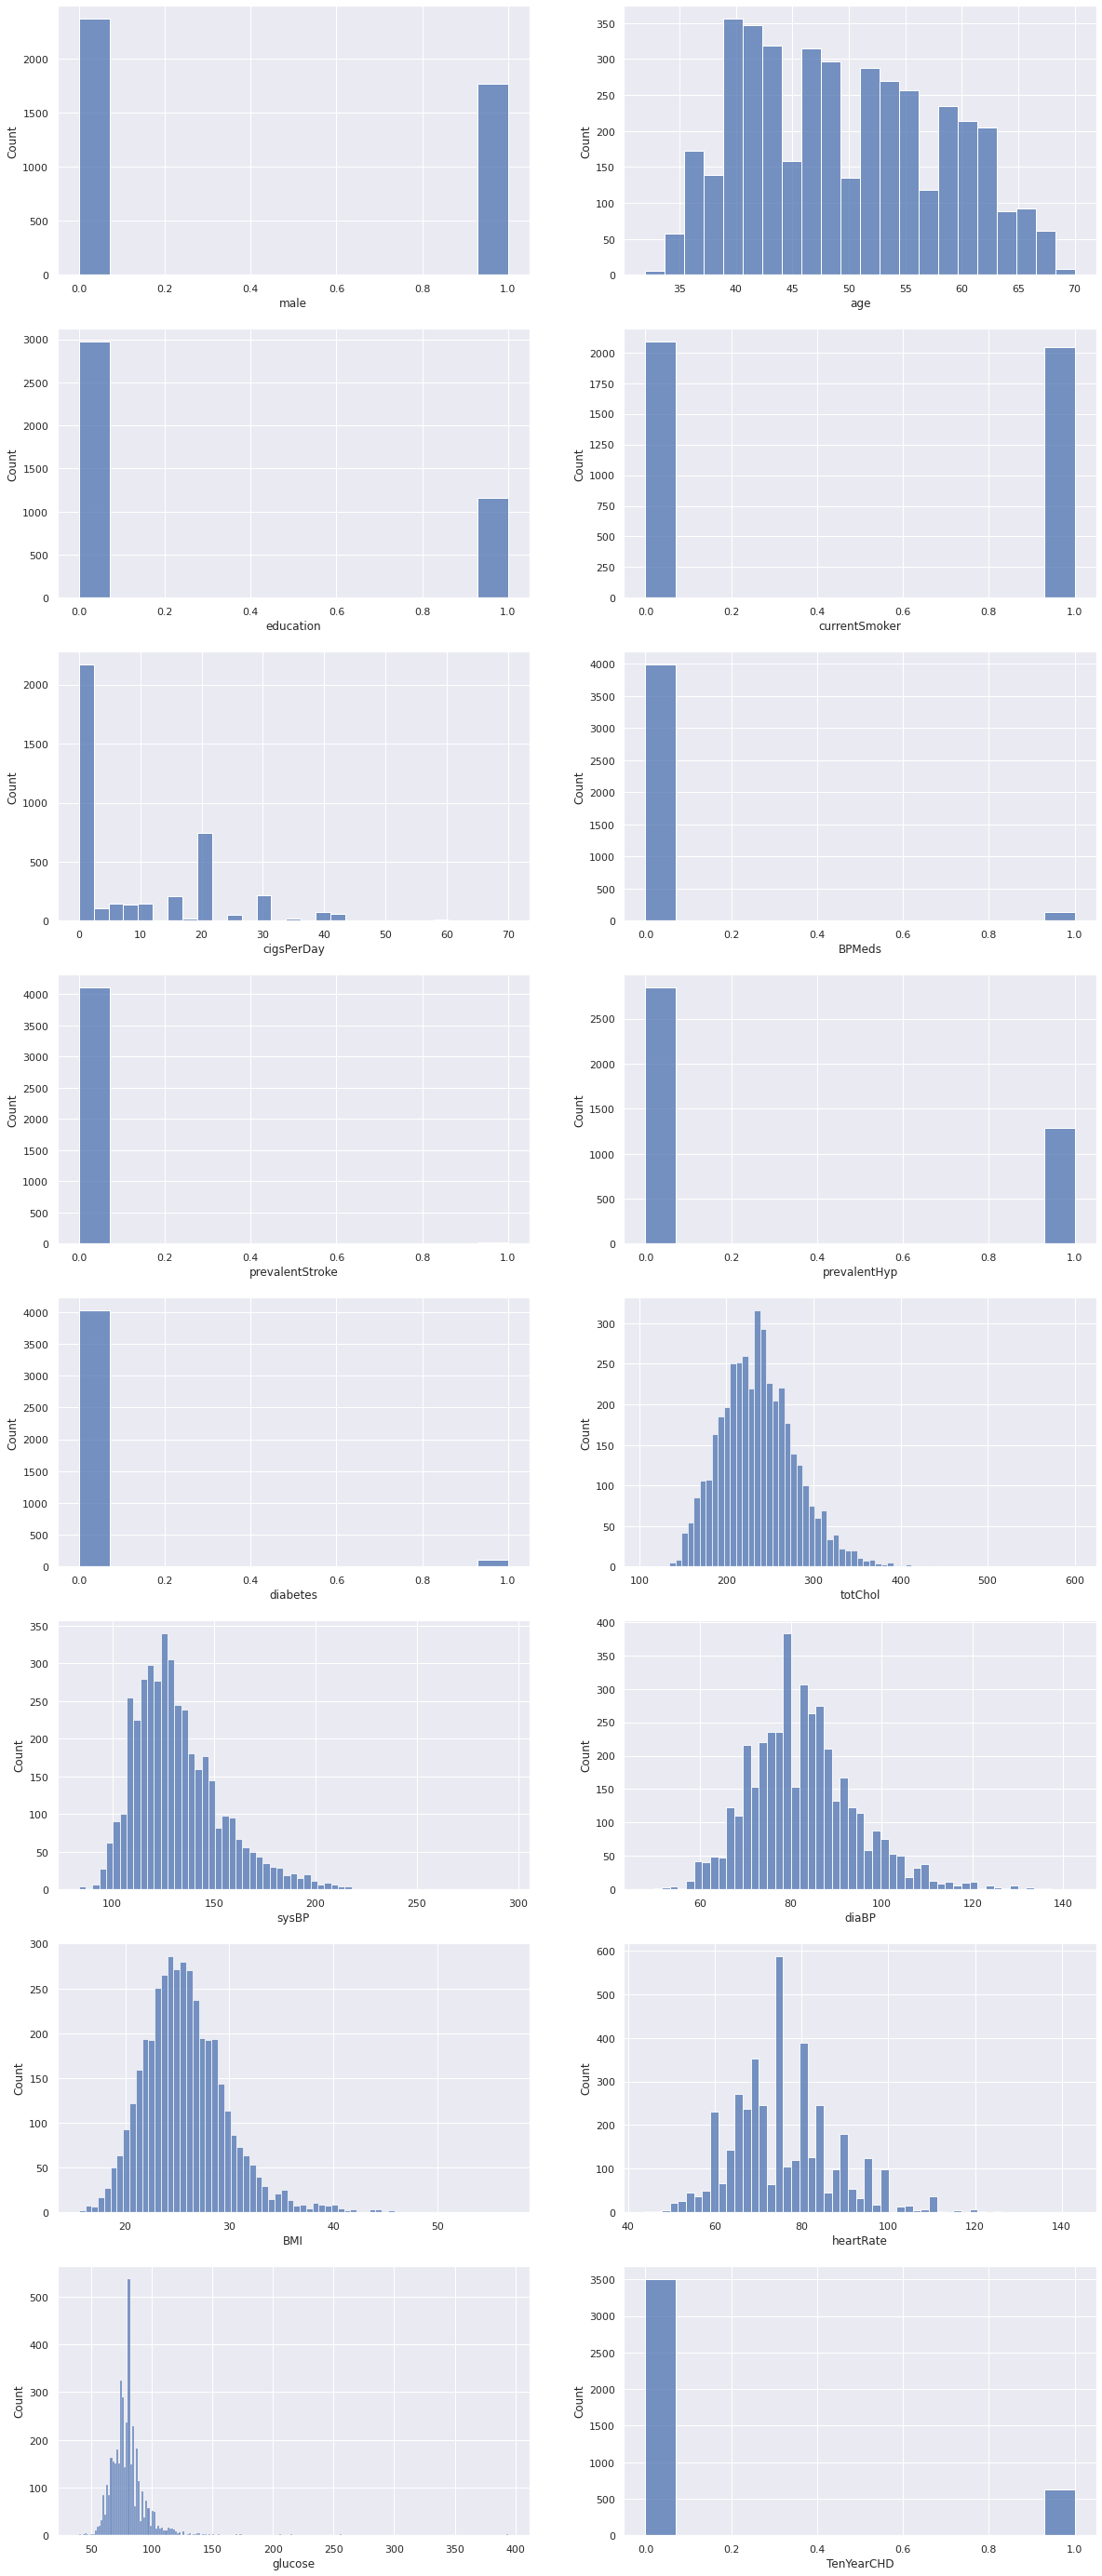

In [ ]:
plt.rcParams['figure.figsize'] = [20, 50]
for i, column in enumerate(chd_pd.columns, 1):
    plt.subplot(8,2,i)
    sns.histplot(chd_pd[column])

# Distribution Analysis
- cigPerDay is skewed for 0, since most of the subjects didn't smoke at all. This may produce a bias for non smokers(although smoking can increase heart related issues GK:)).
- BPmeds and PrevelantStroke data are too skewed for 0 and final model will get biased so it might be best to not include them in the model.
- Diabetes is skewed as well, but can be used(need to keep an eye on the model.)
- TenYearCHD is our target variable and is biased for 0, this is not good for the final model and F1,Precision must be used instead of accuracy.

# Logistic Regression(Without Feature Scaler)

In [ ]:
feature_columns = chd_spark.columns[:-1] # here we omit the final column
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

#Feature Selection
assembler = VectorAssembler(inputCols=feature_columns,outputCol="features")
chd_spark2 = assembler.transform(chd_spark)
# chd_spark2.show()

#Split
train, test = chd_spark2.randomSplit([0.7, 0.3])

#model Definition
algo = LogisticRegression(
    featuresCol="features", 
    labelCol="TenYearCHD",
    maxIter=10)

#Training
model = algo.fit(train)

#Evaluation
training_summary = model.evaluate(train) 
evaluation_summary = model.evaluate(test)


print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))
print("Accuracy(Train): " + str(training_summary.accuracy))
print("Accuracy(Test): " + str(evaluation_summary.accuracy))

Coefficients: [0.5330536294335539,0.0636247800808564,0.018774478922063603,-0.1933908982144864,0.02695679403377151,0.13452458008420473,0.7972744221715844,0.15876769139361324,0.29232653305446255,0.0022752939081626023,0.016000240539711923,-0.0010418345891311425,0.0007141143194151817,0.0032481642664957794,0.004135649639373917]
Intercept: -8.751414266760156
Accuracy(Train): 0.8519290928050052
Accuracy(Test): 0.8606687898089171


In [ ]:
# predictions = model.transform(test)

In [ ]:
# trainingSummary = model.summary

# # Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

# # Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
# trainingSummary.roc.show()
# print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# # Set the model threshold to maximize F-Measure
# fMeasure = trainingSummary.fMeasureByThreshold
# maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('threshold').head()['threshold']
# model.setThreshold(bestThreshold)



---
# 1. Logistic Regression(with Feature Scaling)


In [ ]:
from pyspark.ml.feature import StandardScaler
standardscaler = StandardScaler().setInputCol("features").setOutputCol("scaledFeatures")

# then, fit and transform dataset
chd_spark2_scaled = standardscaler.fit(chd_spark2).transform(chd_spark2)
chd_spark2_scaled.select("Features",'TenYearCHD','scaledFeatures').show(5, False)

+-------------------------------------------------------------------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Features                                                                 |TenYearCHD|scaledFeatures                                                                                                                                                                                                          |
+-------------------------------------------------------------------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[1.0,39.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,195.0,106.0,70.0,26.97,80.0,77.0]  |0         |[2

In [ ]:
train_scaled, test_scaled = chd_spark2_scaled.randomSplit([0.7, 0.3])

#model Definition
algo_scaled = LogisticRegression(
    featuresCol="scaledFeatures", 
    labelCol="TenYearCHD",
    maxIter=10)

#Training
model_scaled = algo_scaled.fit(train_scaled)

#Evaluation
training_scaled_summary = model_scaled.evaluate(train_scaled) 
evaluation_scaled_summary = model_scaled.evaluate(test_scaled)


print("Coefficients: " + str(model_scaled.coefficients))
print("Intercept: " + str(model_scaled.intercept))
print("Accuracy(Train): " + str(training_scaled_summary.accuracy))
print("Accuracy(Test): " + str(evaluation_scaled_summary.accuracy))

Coefficients: [0.18215911221274217,0.5887393570781694,0.007360403513480772,-0.0167145273539814,0.29977221225236567,0.021754822558473177,0.11050524871228003,0.12110617906640037,0.022098891528114843,0.08063093527817716,0.28138768329660924,0.007466893309434436,0.035915753954195495,-0.08148225780189403,0.11731457751867067]
Intercept: -8.185901286119964
Accuracy(Train): 0.8591893780573026
Accuracy(Test): 0.8536585365853658


# 2. Decision Tree Classifier(With Scaled Features)

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

decision_tree_class = GBTClassifier(labelCol="TenYearCHD", featuresCol="scaledFeatures")

# let's fit the model
decision_tree_model = decision_tree_class.fit(train_scaled)

# let's predict the model on test and train set
decision_tree_prediction_train = decision_tree_model.transform(train_scaled)
decision_tree_prediction_test = decision_tree_model.transform(test_scaled)

decision_tree_accuracy_train = (MulticlassClassificationEvaluator(labelCol = "TenYearCHD", predictionCol = "prediction", metricName = "accuracy")).evaluate(decision_tree_prediction_train)
decision_tree_accuracy_test = (MulticlassClassificationEvaluator(labelCol = "TenYearCHD", predictionCol = "prediction", metricName = "accuracy")).evaluate(decision_tree_prediction_test)

print("Accuracy(Train): " + str(decision_tree_accuracy_train))
print("Accuracy(Test): " + str(decision_tree_accuracy_test))

Accuracy(Train): 0.8892382948986722
Accuracy(Test): 0.8316286388670339


# 3. GBT Classifier(With Scaled Features)

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

gradient_boost_class = GBTClassifier(labelCol="TenYearCHD", featuresCol="scaledFeatures")

# let's fit the model
gradient_boost_model = gradient_boost_class.fit(train_scaled)

# let's predict the model on test and train set
gradient_boost_prediction_train = gradient_boost_model.transform(train_scaled)
gradient_boost_prediction_test = gradient_boost_model.transform(test_scaled)

gradient_boost_accuracy_train = (MulticlassClassificationEvaluator(labelCol = "TenYearCHD", predictionCol = "prediction", metricName = "accuracy")).evaluate(gradient_boost_prediction_train)
gradient_boost_accuracy_test = (MulticlassClassificationEvaluator(labelCol = "TenYearCHD", predictionCol = "prediction", metricName = "accuracy")).evaluate(gradient_boost_prediction_test)

# print("Coefficients: " + str(gradient_boost_model.coefficients))
# print("Intercept: " + str(gradient_boost_model.intercept))
print("Accuracy(Train): " + str(gradient_boost_accuracy_train))
print("Accuracy(Test): " + str(gradient_boost_accuracy_test))

Accuracy(Train): 0.8892382948986722
Accuracy(Test): 0.8316286388670339


# 4. Random Forest(With Scaled Features)

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
random_forest_classifier = RandomForestClassifier(labelCol="TenYearCHD", featuresCol="scaledFeatures", numTrees=40)

random_forest_model = random_forest_classifier.fit(train_scaled)

# let's predict the model on test and train set
random_forest_model_prediction_train = random_forest_model.transform(train_scaled)
random_forest_model_prediction_test = random_forest_model.transform(test_scaled)

random_forest_model_accuracy_train = (MulticlassClassificationEvaluator(labelCol = "TenYearCHD", predictionCol = "prediction", metricName = "accuracy")).evaluate(random_forest_model_prediction_train)
random_forest_model_accuracy_test = (MulticlassClassificationEvaluator(labelCol = "TenYearCHD", predictionCol = "prediction", metricName = "accuracy")).evaluate(random_forest_model_prediction_test)

# print("Coefficients: " + str(gradient_boost_model.coefficients))
# print("Intercept: " + str(gradient_boost_model.intercept))
print("Accuracy(Train): " + str(random_forest_model_accuracy_train))
print("Accuracy(Test): " + str(random_forest_model_accuracy_test))

Accuracy(Train): 0.8529000698812019
Accuracy(Test): 0.8434303697875688
